# Exponential Mechanism
This notebook contains the code used to reproduce the mechanism of (Yue et al., 2021). This code was used in Section 7 of the paper to compare it with our fixed mechanism

In [ ]:
import pickle
from os.path import join
import numpy as np
from collections import Counter
from scipy.special import softmax
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import sys

# Add the main directory to sys.path to be able to import config
sys.path.append(str(Path.cwd().parent))
from config import ROOT_DIR
from utils.tools import compute_distances, rank_neighbors

# PARAMS
number_of_words = 5000
glove_variant = "6B"  # "6B" or "Twitter"
hidden_size = 300
# END PARAMS

glove_data_folderpath = ROOT_DIR
distance_metric = "euclidean"  # Metric to use for the distances
distances_dtype = np.float32  # Precision of the distances
# !!! float32 (at least) needed to avoid overflow when computing probabilities
if glove_variant == "6B":
    glove_dimension_to_filename = {
        50: "glove.6B.50d.pkl",  # 400000 words
        100: "glove.6B.100d.pkl",  # 400000 words
        200: "glove.6B.200d.pkl",  # 400000 words
        300: "glove.6B.300d.pkl",  # 400000 words
    }
elif glove_variant == "Twitter":
    glove_dimension_to_filename = {
        25: "glove.twitter.27B.25d.pkl",  # 1,193,513 words
        50: "glove.twitter.27B.50d.pkl",  # 1,193,513 words
        100: "glove.twitter.27B.100d.pkl",  # 1,193,513 words
        200: "glove.twitter.27B.200d.pkl",  # 1,193,513 words
    }
fit_dtype = (
    np.uint32
)  # Integer size sufficient to encode the number of words in the vocabularies

Load GloVe in a specific dimension

In [ ]:
with open(
    join(glove_data_folderpath, glove_dimension_to_filename[hidden_size]), "rb"
) as f:
    glove = pickle.load(f)

vocab_embs = np.array(list(glove.values()))
vocab_size = vocab_embs.shape[0]
del glove  # Save RAM

CPU times: user 1.21 s, sys: 1.12 s, total: 2.33 s
Wall time: 2.33 s


Select *number_of_words* random words and compute their distance with all the words in the embedding space.

In [ ]:
words_ids = np.random.choice(vocab_size, size=number_of_words, replace=False)
words_embs = vocab_embs[words_ids]

# Get the distances between the selected words and the entire vocabulary
distances = compute_distances(
    words_embs, vocab_embs, distance_metric, dtype=distances_dtype
)

# Also rank the entire vocabulary
words_neighbors_ranked = rank_neighbors(words_embs, vocab_embs, distance_metric)

CPU times: user 11.6 s, sys: 8.62 s, total: 20.2 s
Wall time: 20.4 s


Apply the SANTEXT mechanism detailed in Algorithm 1 of (Yue et al., 2021). For each word $\mathbf{x}$ selected above, compute the probability that they are substituted by each word $\mathbf{y}$ in the vocabulary:
$$\frac{\exp(- \frac{1}{2} \epsilon d_\text{euc}(\mathbf{x}, \mathbf{y}))}{\sum_{\mathbf{x} \in \mathcal{D}} \exp(- \frac{1}{2} \epsilon d_\text{euc}(\mathbf{x}, \mathbf{y}))}
$$

In [ ]:
epsilons = np.arange(0.5, 6.1, 0.1)  # Parameter depending on the GloVe version selected
neighbor_counted_occurences = {}

# Process epsilons in parallel
n_workers = 2


def process_epsilon(epsilon):
    # Compute the probabilities
    probabilities = softmax(-1 / 2 * epsilon * distances, axis=-1)

    # Sample one replacement for each word
    noisy_word_ids = [
        np.random.choice(vocab_size, p=probabilities[i]) for i in range(number_of_words)
    ]

    # for all words_ids, get the rank k of noisy_word_ids[i] and increase a counter at index k
    noisy_word_ids_ranks = words_neighbors_ranked[
        np.arange(number_of_words), noisy_word_ids
    ]  # This line, for all the elements i in the first dimension of words_neighbors_ranked, gets the particular value pointed by the index which is stored at noisy_word_ids[i]

    noisy_word_ids_ranks_counted = Counter(noisy_word_ids_ranks)
    return [noisy_word_ids_ranks_counted[k] for k in range(vocab_size)]


with ProcessPoolExecutor(max_workers=n_workers) as executor:
    results = list(executor.map(process_epsilon, epsilons))

neighbor_counted_occurences = dict(zip(epsilons, results))

CPU times: user 1.28 s, sys: 824 ms, total: 2.1 s
Wall time: 16min


Results are stored in *neighbor_counted_occurences*, which is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with a list, where list[i] contains the number of times the i-th neighbor was chosen as the replacement of a word. 

Plot

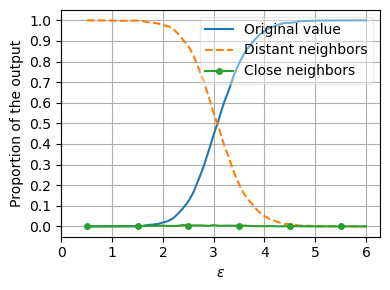

In [7]:
import matplotlib.pyplot as plt
close_neighbors_max_rank = 100 # The maximum rank (including) of what is considered a "close" neighbor 

initial_word_frequency = np.array([neighbor_counted_occurences[i][0] for i in epsilons])
close_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][1:close_neighbors_max_rank+1]) for i in epsilons])
distant_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][close_neighbors_max_rank+1:]) for i in epsilons])

fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(epsilons, initial_word_frequency/number_of_words, label="Original value", linewidth=1.5, markersize=5)
ax.plot(epsilons, distant_neighbors_frequency/number_of_words, label="Distant neighbors", linewidth=1.5,linestyle='dashed')
ax.plot(epsilons, close_neighbors_frequency/number_of_words, label="Close neighbors", linewidth=1.5, marker=".", markevery=10, markersize=8)

ax.set_xlabel("$\epsilon$")
ax.set_ylabel("Proportion of the output")
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_xlim(0,)
ax.legend(loc="upper right", framealpha=0.4)
ax.grid()
fig.tight_layout()
fig.show()